In [1]:
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 5.2 MB/s 


In [2]:
import nltk #import library nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory #import Indonesian Stemmer
import json
import pickle

import numpy as np
import random

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

words = []
classes = []
documents = []
ignored_words = ['?', '!']
data_file = open('/content/drive/MyDrive/DemoDay/intents.json').read()
intents = json.loads(data_file)

In [6]:
nltk.download('punkt')

# memisahkan kalimat dalam file intents
for intent in intents['intents']:
    for pattern in intent['patterns']:
        # memisahkan setiap kata
        word_tokens = nltk.word_tokenize(pattern)
        words.extend(word_tokens)
        # tambahkan ke daftar dokumen (corpus)
        documents.append((word_tokens, intent['tag']))
        # tambahkan tag ke daftar kelas
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
# Membersihkan data: lowercase dan menghapus duplikat
words = [stemmer.stem(word.lower()) for word in words if word not in ignored_words]
words = sorted(list(set(words)))
# Urutkan kelas
classes = sorted(list(set(classes)))

# Simpan kata dan kelas ke file pickle
pickle.dump(words, open("/content/drive/MyDrive/DemoDay/words.pkl", 'wb'))
pickle.dump(classes, open('/content/drive/MyDrive/DemoDay/classes.pkl', 'wb'))

In [8]:
# Buat data pelatihan
training = []
# Daftar kosong untuk output
output_empty = [0] * len(classes)
# "Bag of Words" untuk setiap kalimat
for document in documents:
    bag_of_words = []
    # membuat daftar kata-kata yang dipisahkan dalam pola
    pattern_words = document[0]
    # stem kata pola
    pattern_words = [stemmer.stem(word.lower()) for word in pattern_words]
    # menambahkan 1 ke bag of words jika kecocokan kata ditemukan dalam pola saat ini, jika tidak 0
    for word in words:
        if word in pattern_words:
            bag_of_words.append(1)
        else:
            bag_of_words.append(0)
    # Outputnya adalah 0 untuk setiap tag dan 1 untuk tag saat ini
    output_row = list(output_empty)
    output_row[classes.index(document[1])] = 1
    training.append([bag_of_words, output_row])

# Fitur acak untuk membuat array numpy
random.shuffle(training)
training = np.array(training)

# Buat set train dan tes
train_patterns = list(training[:,0])
train_intents = list(training[:,1])

print("Data Training sudah dibuat.")

Data Training sudah dibuat.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [9]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD

In [10]:
# Buat model 3 layer.
# Layer 1: 128 neurons
# Layer 2: 64 neurons
# Layer 3: jumlah neuron sama dengan # intents untuk memprediksi intents keluaran dengan softmax
model = Sequential()
model.add(Dense(128, input_shape = (len(train_patterns[0]),),  activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_intents[0]), activation = 'softmax'))

In [11]:
# Kompilasi model.
sgd = SGD(learning_rate= 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])

In [12]:
# Fit model
hist = model.fit(np.array(train_patterns), np.array(train_intents), epochs = 200, batch_size = 5, verbose = 1)
model.save('/content/drive/MyDrive/DemoDay/chatbot_model.h5', hist)

print('Model telah dibuat.')

Epoch 1/200
13/13 [==============================] - 3s 3ms/step - loss: 3.2069 - accuracy: 0.0484 
Epoch 2/200
13/13 [==============================] - 0s 3ms/step - loss: 3.1324 - accuracy: 0.0161
Epoch 3/200
13/13 [==============================] - 0s 3ms/step - loss: 3.0171 - accuracy: 0.1129
Epoch 4/200
13/13 [==============================] - 0s 3ms/step - loss: 2.9430 - accuracy: 0.1935
Epoch 5/200
13/13 [==============================] - 0s 3ms/step - loss: 2.8015 - accuracy: 0.2419
Epoch 6/200
13/13 [==============================] - 0s 3ms/step - loss: 2.7198 - accuracy: 0.2742
Epoch 7/200
13/13 [==============================] - 0s 3ms/step - loss: 2.6027 - accuracy: 0.3065
Epoch 8/200
13/13 [==============================] - 0s 3ms/step - loss: 2.5737 - accuracy: 0.2419
Epoch 9/200
13/13 [==============================] - 0s 3ms/step - loss: 2.4468 - accuracy: 0.3387
Epoch 10/200
13/13 [==============================] - 0s 3ms/step - loss: 2.3800 - accuracy: 0.3387
Epoch 11

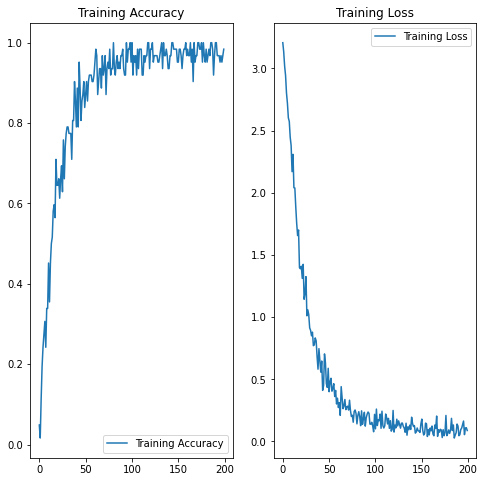

In [14]:
import matplotlib.pyplot as plt

# Menampilkan hasil akurasi training dan validation
acc = hist.history['accuracy']

loss = hist.history['loss']

epochs_range = range(200)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()